In [ ]:
import os
from os.path import dirname, basename
from tifffile import imread
from shapely.geometry import Point, Polygon, LinearRing
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
folder_data = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT/selected_condensates_best"
os.chdir(folder_data)
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT"

all_files = os.listdir(".")
lst_fname_left_csv = [f for f in all_files if f.endswith("left.csv")]
lst_fname_left_PAINT = [
    f.split("left.csv")[0] + "left-PAINT.tif" for f in lst_fname_left_csv
]
lst_fname_right_csv = [f.split("left.csv")[0] + "right.csv" for f in lst_fname_left_csv]
lst_fname_right_PAINT = [
    f.split("left.csv")[0] + "right-PAINT.tif" for f in lst_fname_left_csv
]


## Pair Correlation

In [ ]:
# Parameters
nm_per_pxl = 117  # ONI scale
r_max_nm = 610
ringwidth_nm = 100
dr_slidingrings_nm = 10  # stepsize between adjascent overlaping rings, nm
bins = np.arange(
    0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
)  # overlaping bins (sliding window)
# round UP for boundary correction, see function PairCorrelation_perCell()
r_max_pxl = math.ceil(r_max_nm / 117)
bins

In [305]:
def cnt2mask(imgshape, contours):
    # create empty image
    mask = np.zeros(imgshape, dtype=np.uint8)
    # draw contour
    for cnt in contours:
        cv2.fillPoly(mask, [cnt], (255))
    return mask


def single_condensate_stepsize_img(df_track, img_shape):
    ## Reconstruct step size iamge, unit: um
    lst_mid_x = []
    lst_mid_y = []
    lst_stepsize = []
    all_trackID = df_track["trackID"].unique()
    for trackID in all_trackID:
        df_current = df_track[df_track["trackID"] == trackID]
        xs = df_current["x"].to_numpy(float)
        ys = df_current["y"].to_numpy(float)
        mid_xs = (xs[1:] + xs[:-1]) / 2
        mid_ys = (ys[1:] + ys[:-1]) / 2
        steps = (
            np.sqrt((xs[1:] - xs[:-1]) ** 2 + (ys[1:] - ys[:-1]) ** 2) * um_per_pixel
        )
        lst_mid_x.extend(mid_xs)
        lst_mid_y.extend(mid_ys)
        lst_stepsize.extend(steps)

    df_all_steps = pd.DataFrame(
        {
            "mid_x": lst_mid_x,
            "mid_y": lst_mid_y,
            "stepsize": lst_stepsize,
        },
        dtype=float,
    )

    # put them in grid, calculate mean
    img_stepsize = np.zeros(img_shape)
    for x in range(img_stepsize.shape[0]):
        for y in range(img_stepsize.shape[1]):
            df_current = df_all_steps[
                df_all_steps["mid_x"].between(x, x + 1)
                & df_all_steps["mid_y"].between(y, y + 1)
            ]
            mean_stepsize = df_current["stepsize"].mean()
            img_stepsize[x, y] = mean_stepsize

    return img_stepsize


def corr_within_mask(df, mask):
    """
    Take a Polygon mask and a dataframe contain columns 'x' and 'y', and return numpy array of x and y within the mask.
    """
    lst_x = []
    lst_y = []
    for _, row in df.iterrows():
        if Point(row.x, row.y).within(mask):
            lst_x.append(row.x)
            lst_y.append(row.y)
    array_x = np.array(lst_x, dtype=float)
    array_y = np.array(lst_y, dtype=float)
    return array_x, array_y


def filter_tracks(df):
    scaling_factor = 1
    tracklength_threshold = 10
    # single-frame spots
    df_single_frame_spots = df[df["trackID"].isna()]
    spots_x = df_single_frame_spots.x.to_numpy(float)
    spots_y = df_single_frame_spots.y.to_numpy(float)
    # tracks
    df_tracks = df[df["trackID"].notna()]
    all_trackID = df_tracks["trackID"].unique()
    lst_of_arr_x = []
    lst_of_arr_y = []
    for trackID in all_trackID:
        df_current = df_tracks[df_tracks["trackID"] == trackID]
        # for short tracks, treat as spots
        if df_current.shape[0] <= tracklength_threshold:
            lst_of_arr_x.append(df_current["x"].to_numpy(float) * scaling_factor)
            lst_of_arr_y.append(df_current["y"].to_numpy(float) * scaling_factor)
            continue
        # for long tracks, randomly pick tracklength_threshold number of spots
        else:
            chosen_idx = np.random.choice(df_current.shape[0], tracklength_threshold)
            lst_of_arr_x.append(
                df_current.iloc[chosen_idx]["x"].to_numpy(float) * scaling_factor
            )
            lst_of_arr_y.append(
                df_current.iloc[chosen_idx]["y"].to_numpy(float) * scaling_factor
            )
            continue

    tracks_x = np.hstack(lst_of_arr_x)
    tracks_y = np.hstack(lst_of_arr_y)

    df_out = pd.DataFrame(
        {
            "x": np.concatenate(
                [
                    spots_x,
                    tracks_x,
                ]
            ),
            "y": np.concatenate(
                [
                    spots_y,
                    tracks_y,
                ]
            ),
        },
        dtype=float,
    )

    return df_out


def filter_tracksonly(df):
    scaling_factor = 1
    tracklength_threshold = 5
    df_tracks = df[df["trackID"].notna()]
    all_trackID = df_tracks["trackID"].unique()
    lst_x = []
    lst_y = []
    for trackID in all_trackID:
        df_current = df_tracks[df_tracks["trackID"] == trackID]
        if df_current.shape[0] >= tracklength_threshold:
            lst_x.append(df_current["x"].mean() * scaling_factor)
            lst_y.append(df_current["y"].mean() * scaling_factor)

    tracks_x = np.array(lst_x, dtype=float)
    tracks_y = np.array(lst_y, dtype=float)

    df_out = pd.DataFrame({"x": tracks_x, "y": tracks_y}, dtype=float)

    return df_out


def spots2PAINT_single_condensate(df, frame_size_x, frame_size_y):
    # The whole df would be used for reconstructure, dispite track or spot
    tracklength_threshold = 10
    xedges = np.arange(frame_size_x + 1)
    yedges = np.arange(frame_size_y + 1)
    img_PAINT, _, _ = np.histogram2d(
        x=df["x"].to_numpy(float),
        y=df["y"].to_numpy(float),
        bins=(xedges, yedges),
    )
    return img_PAINT


def PairCorr_with_edge_correction(df_ref, df_interest, mask):
    # only count particles within mask
    x_ref, y_ref = corr_within_mask(df_ref, mask)
    x_interest, y_interest = corr_within_mask(df_interest, mask)

    # Total number particles in mask
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle density rho, unit: number per nano meter square
    mask_area_nm2 = mask.area * (nm_per_pxl**2)
    rho_ref_per_nm2 = N_ref / mask_area_nm2
    rho_interest_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    bin_ends = bin_starts + ringwidth_nm
    ring_areas_nm2 = np.pi * (
        bin_ends**2 - bin_starts**2
    )  # area of rings, unit nm square
    ring_areas_pxl2 = ring_areas_nm2 / (nm_per_pxl**2)

    # Calculate corrected histogram of distances
    lst_hist_per_point_cross = []
    lst_hist_per_point_auto_ref = []
    for i in track(range(len(x_ref))):
        # Calculate edge correction factor
        rings = [
            Point(x_ref[i], y_ref[i])
            .buffer(end)
            .difference(Point(x_ref[i], y_ref[i]).buffer(start))
            for start, end in zip(bin_starts / nm_per_pxl, bin_ends / nm_per_pxl)
        ]
        intersect_areas = np.array(
            [mask.intersection(Polygon(ring), grid_size=0.1).area for ring in rings]
        )
        edge_correction_factors = 1 / (intersect_areas / ring_areas_pxl2)

        # cross correlation
        lst_hist = []
        for j in range(len(x_interest)):
            distance = (
                np.sqrt(
                    (x_ref[i] - x_interest[j]) ** 2 + (y_ref[i] - y_interest[j]) ** 2
                )
                * nm_per_pxl
            )
            lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
        hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
        lst_hist_per_point_cross.append(hist_per_point_corrected)

        # auto correlation - ref
        lst_hist = []
        for j in range(len(x_ref)):
            distance = (
                np.sqrt((x_ref[i] - x_ref[j]) ** 2 + (y_ref[i] - y_ref[j]) ** 2)
                * nm_per_pxl
            )
            lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
        hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
        lst_hist_per_point_auto_ref.append(hist_per_point_corrected)

    # calculate normalization factor that counts for density and ring area
    norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2
    norm_factors_auto_ref = N_ref * ring_areas_nm2 * rho_ref_per_nm2

    PairCorr_cross = np.sum(lst_hist_per_point_cross, axis=0) / norm_factors_cross
    PairCorr_auto_ref = (
        np.sum(lst_hist_per_point_auto_ref, axis=0) / norm_factors_auto_ref
    )

    return PairCorr_cross, PairCorr_auto_ref

In [ ]:
lst_cross = []
lst_autoFUS = []
lst_size = []
for i in track(range(len(lst_fname_left_csv))):
    df_left = pd.read_csv(lst_fname_left_csv[i])
    df_right = pd.read_csv(lst_fname_right_csv[i])
    img_PAINT_left = imread(lst_fname_left_PAINT[i])
    img_PAINT_right = imread(lst_fname_right_PAINT[i])

    img_denoise = gaussian_filter(img_PAINT_left + img_PAINT_right, sigma=1)
    edges = img_denoise >= 10
    # edges = (img_PAINT_left > 5) & (img_PAINT_right > 5)
    contours, _ = cv2.findContours(edges * 1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    mask = cnt2mask(edges.shape, contours)
    contours_final, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # get only the major condensate
    cnt_condensate = contours_final[0]
    for cnt in contours_final:
        if cv2.contourArea(cnt) > cv2.contourArea(cnt_condensate):
            cnt_condensate = cnt

    mask = Polygon(np.squeeze(cnt_condensate))

    # df_left = filter_tracksonly(df_left)
    df_left = filter_tracks(df_left)
    # df_right = filter_tracksonly(df_right)
    df_right = filter_tracks(df_right)

    cross, auto_FUS = PairCorr_with_edge_correction(df_left, df_right, mask)

    data_size = df_left.shape[0]

    plt.figure(figsize=(5, 3))
    plt.axhline(1, c="k", ls="--")
    plt.plot(bins, auto_FUS, "b", label="Auto, FUS")
    plt.plot(bins, cross, "r", label="Cross")
    plt.legend(frameon=False)
    plt.xlim(bins[1], bins[-1])
    plt.ylim(0, 2.3)
    plt.xlabel("r, nm")
    plt.ylabel("G(r)")
    plt.savefig(
        lst_fname_left_csv[i][:-9] + "-PairCorr.png",
        format="png",
        dpi=300,
        bbox_inches="tight",
    )

    lst_cross.append(cross)
    lst_autoFUS.append(auto_FUS)
    lst_size.append(data_size)

In [308]:
lst_fname_left_csv[i][:-9]

'20230928-FOV-6-threshold-10-condensateID-5'

## Testing edge correction

In [ ]:
# Parameters
nm_per_pxl = 117  # ONI scale
r_max_nm = 1120
ringwidth_nm = 100
dr_slidingrings_nm = 20  # stepsize between adjascent overlaping rings, nm
bins = np.arange(
    0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
)  # overlaping bins (sliding window)
# round UP for boundary correction, see function PairCorrelation_perCell()
r_max_pxl = math.ceil(r_max_nm / 117)
bins

In [294]:
# i=7
j=21
df_left = pd.read_csv(lst_fname_left_csv[j])
df_right = pd.read_csv(lst_fname_right_csv[j])
img_PAINT_left = imread(lst_fname_left_PAINT[j])
img_PAINT_right = imread(lst_fname_right_PAINT[j])
print(df_left.shape[0], df_right.shape[0])

df_left = filter_tracksonly(df_left)
# df_left = filter_tracks(df_left)
df_right = filter_tracksonly(df_right)
# df_right = filter_tracks(df_right)
print(df_left.shape[0], df_right.shape[0])

img_denoise = gaussian_filter(img_PAINT_left + img_PAINT_right, sigma=1)
edges = img_denoise >= 5
# edges = (img_PAINT_left > 5) & (img_PAINT_right > 5)
contours, _ = cv2.findContours(edges * 1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
mask = cnt2mask(edges.shape, contours)
contours_final, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# get only the major condensate
cnt_condensate = contours_final[0]
for cnt in contours_final:
    if cv2.contourArea(cnt) > cv2.contourArea(cnt_condensate):
        cnt_condensate = cnt

mask_large = Polygon(np.squeeze(cnt_condensate))



7964 8465
126 363


11113 3739
280 125

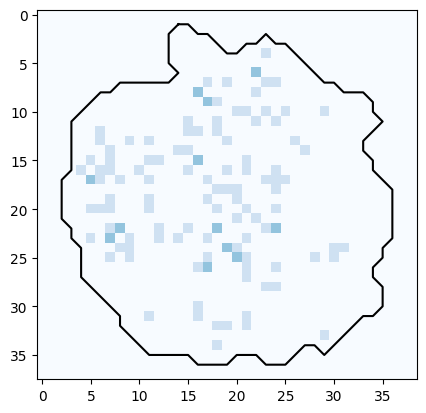

In [300]:
plt.imshow(
    spots2PAINT_single_condensate(
        df_left, img_PAINT_left.shape[1], img_PAINT_left.shape[0]
    ),
    cmap="Blues",
    vmin=0,
    vmax=5,
)
x, y = mask_large.exterior.xy
plt.plot(x, y, "k")
plt.savefig("21-PAINT_left.png", format="png", dpi=300, bbox_inches="tight")

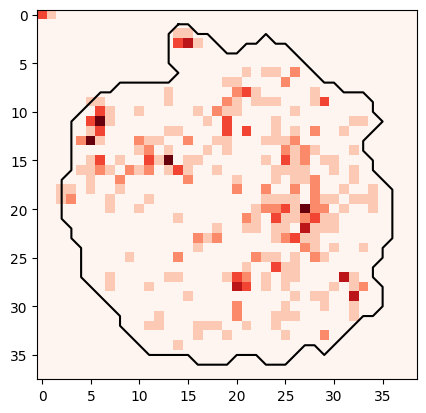

In [302]:
plt.imshow(
    spots2PAINT_single_condensate(
        df_right, img_PAINT_right.shape[1], img_PAINT_right.shape[0]
    ),
    cmap="Reds",
    vmin=0,
    vmax=5,
)
x, y = mask_large.exterior.xy
plt.plot(x, y, 'k')
plt.savefig("21-PAINT_right.png", format="png", dpi=300, bbox_inches='tight')

In [287]:
df_interest = df_right
mask = mask_large
df_ref = df_left

# only count particles within mask
x_ref, y_ref = corr_within_mask(df_ref, mask)
x_interest, y_interest = corr_within_mask(df_interest, mask)

# Total number particles in cell
N_ref = x_ref.shape[0]
N_interest = x_interest.shape[0]

# particle density rho, unit: number per nano meter square
mask_area_nm2 = mask.area * (nm_per_pxl**2)
rho_ref_per_nm2 = N_ref / mask_area_nm2
rho_interest_per_nm2 = N_interest / mask_area_nm2

# setup bins and ring areas
bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
bin_ends = bin_starts + ringwidth_nm
ring_areas_nm2 = np.pi * (
    bin_ends**2 - bin_starts**2
)  # area of rings, unit nm square
ring_areas_pxl2 = ring_areas_nm2 / (nm_per_pxl**2)

# Calculate corrected histogram of distances
lst_hist_per_point_cross = []
lst_hist_per_point_auto_ref = []
for i in track(range(len(x_ref))):
    # Calculate edge correction factor
    rings = [
        Point(x_ref[j], y_ref[j])
        .buffer(end)
        .difference(Point(x_ref[j], y_ref[j]).buffer(start))
        for start, end in zip(bin_starts / nm_per_pxl, bin_ends / nm_per_pxl)
    ]
    intersect_areas = np.array(
        [mask.intersection(Polygon(ring), grid_size=0.1).area for ring in rings]
    )
    edge_correction_factors = 1 / (intersect_areas / ring_areas_pxl2)
    # if edge_correction_factors[0] > 1.2:
    #     continue
    # plt.plot(bins, edge_correction_factors, alpha=0.5)

    # cross correlation
    lst_hist = []
    for j in range(len(x_interest)):
        distance = (
            np.sqrt((x_ref[j] - x_interest[k]) ** 2 + (y_ref[j] - y_interest[k]) ** 2)
            * nm_per_pxl
        )
        lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
    hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
    lst_hist_per_point_cross.append(hist_per_point_corrected)

    # auto correlation - ref
    lst_hist = []
    for j in range(len(x_ref)):
        distance = (
            np.sqrt((x_ref[j] - x_ref[k]) ** 2 + (y_ref[j] - y_ref[k]) ** 2)
            * nm_per_pxl
        )
        lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
    hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
    lst_hist_per_point_auto_ref.append(hist_per_point_corrected)

Output()

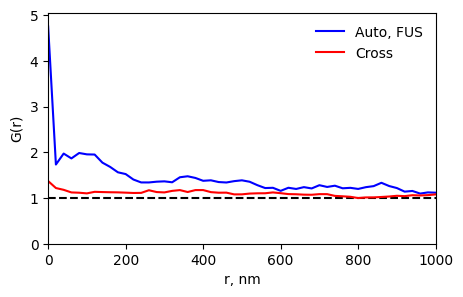

In [291]:
# calculate normalization factor that counts for density and ring area
norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2
norm_factors_auto_ref = N_ref * ring_areas_nm2 * rho_ref_per_nm2

PairCorr_cross = np.sum(lst_hist_per_point_cross, axis=0) / norm_factors_cross
PairCorr_auto_ref = np.sum(lst_hist_per_point_auto_ref, axis=0) / norm_factors_auto_ref

plt.figure(figsize=(5,3))
plt.axhline(1, c="k", ls="--")
plt.plot(bins, PairCorr_auto_ref, "b", label="Auto, FUS")
plt.plot(bins, PairCorr_cross, "r", label="Cross")
plt.legend(frameon=False)
plt.xlim(bins.min(), bins.max())
plt.ylim(0, PairCorr_auto_ref.max() + 0.3)
plt.xlabel("r, nm")
plt.ylabel('G(r)')
plt.savefig("21-PairCorr.png", format="png", dpi=300, bbox_inches='tight')

In [267]:
for i in track(range(len(lst_fname_left_csv))):
    df_left = pd.read_csv(lst_fname_left_csv[i])
    df_right = pd.read_csv(lst_fname_right_csv[i])

    df_left = filter_tracksonly(df_left)
    # df_left = filter_tracks(df_left)
    img_PAINT_left = imread(lst_fname_left_PAINT[i])
    df_right = filter_tracksonly(df_right)
    # df_right = filter_tracks(df_right)
    img_PAINT_right = imread(lst_fname_right_PAINT[i])

    img_denoise = gaussian_filter(img_PAINT_left + img_PAINT_right, sigma=1)
    edges = img_denoise >= 10
    # edges = (img_PAINT_left > 5) & (img_PAINT_right > 5)
    contours, _ = cv2.findContours(edges * 1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    mask = cnt2mask(edges.shape, contours)
    contours_final, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # get only the major condensate
    cnt_condensate = contours_final[0]
    for cnt in contours_final:
        if cv2.contourArea(cnt) > cv2.contourArea(cnt_condensate):
            cnt_condensate = cnt

    mask_large = Polygon(np.squeeze(cnt_condensate))

    df_interest = df_right
    mask = mask_large
    df_ref = df_left

    # only count particles within mask
    x_ref, y_ref = corr_within_mask(df_ref, mask)
    x_interest, y_interest = corr_within_mask(df_interest, mask)

    # Total number particles in cell
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle density rho, unit: number per nano meter square
    mask_area_nm2 = mask.area * (nm_per_pxl**2)
    rho_ref_per_nm2 = N_ref / mask_area_nm2
    rho_interest_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    bin_ends = bin_starts + ringwidth_nm
    ring_areas_nm2 = np.pi * (
        bin_ends**2 - bin_starts**2
    )  # area of rings, unit nm square
    ring_areas_pxl2 = ring_areas_nm2 / (nm_per_pxl**2)

    # Calculate corrected histogram of distances
    lst_hist_per_point_cross = []
    lst_hist_per_point_auto_ref = []
    for j in range(len(x_ref)):
        # Calculate edge correction factor
        rings = [
            Point(x_ref[j], y_ref[j])
            .buffer(end)
            .difference(Point(x_ref[j], y_ref[j]).buffer(start))
            for start, end in zip(bin_starts / nm_per_pxl, bin_ends / nm_per_pxl)
        ]
        intersect_areas = np.array(
            [mask.intersection(Polygon(ring), grid_size=0.1).area for ring in rings]
        )
        edge_correction_factors = 1 / (intersect_areas / ring_areas_pxl2)

        # cross correlation
        lst_hist = []
        for k in range(len(x_interest)):
            distance = (
                np.sqrt((x_ref[j] - x_interest[k]) ** 2 + (y_ref[j] - y_interest[k]) ** 2)
                * nm_per_pxl
            )
            lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
        hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
        lst_hist_per_point_cross.append(hist_per_point_corrected)

        # auto correlation - ref
        lst_hist = []
        for k in range(len(x_ref)):
            distance = (
                np.sqrt((x_ref[j] - x_ref[k]) ** 2 + (y_ref[j] - y_ref[k]) ** 2)
                * nm_per_pxl
            )
            lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
        hist_per_point_corrected = np.sum(lst_hist, axis=0) * edge_correction_factors
        lst_hist_per_point_auto_ref.append(hist_per_point_corrected)

    # calculate normalization factor that counts for density and ring area
    norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2
    norm_factors_auto_ref = N_ref * ring_areas_nm2 * rho_ref_per_nm2

    PairCorr_cross = np.sum(lst_hist_per_point_cross, axis=0) / norm_factors_cross
    PairCorr_auto_ref = np.sum(lst_hist_per_point_auto_ref, axis=0) / norm_factors_auto_ref

    plt.figure(figsize=(5,3))
    plt.axhline(1, c="k", ls="--")
    plt.plot(bins, PairCorr_auto_ref, "b", label="Auto, FUS")
    plt.plot(bins, PairCorr_cross, "r", label="Cross")
    plt.legend(frameon=False)
    plt.xlim(bins.min(), bins.max())
    plt.ylim(0, PairCorr_auto_ref.max() + 0.3)
    plt.xlabel("r, nm")
    plt.ylabel('G(r)')
    plt.savefig(str(k)+"-PairCorr.png", format="png", dpi=300, bbox_inches='tight')



Output()

In [304]:
lst_fname_left_csv[i][:-4]

'20230928-FOV-6-threshold-10-condensateID-5-left'

## Unused functions

In [ ]:
def PairCorrelation_minus_sampling(df_interest, mask_large, df_ref, mask_small):
    """
    Calculate the pair correlation function, aka. radial distribution function, g(r) between reference particles and particles of interest. It can be used for EITHER auto-pair correlation OR cross-pair correlation.

    I used a so-called 'minus sampling' strategy to perform boundary correction. The mask_large would be the cell boundary, or any boundary of a ROI. The mask_small is mask_large after an erosion of r_max_pxl which is the maximum distance r we care about in g(r). This ensures that we will not exceed the boundary when searching for particles of interest around any reference particle. Otherwise, there would be a drop at the far end of g(r).

    For example, auto-pair correlation could be between RNAs within mask_large and the same RNAs within mask_small as reference particles. This will quantify the clustering of RNAs. Cross-pair correlation could be between RNAs within mask_large and condensates within mask_small as reference particles, This will quantify how close the RNAs reside within or near condensates.

    A good reference is http://www.physics.emory.edu/faculty/weeks//idl/gofr2.html. My algorithm only has two differences: (1) pair distances between particles are calculated at once with numpy array broadcasting, rather than looping through particles; (2) numpy histogram binned at the ring width dr is used to substitue looping over rings. Both improvements make the algorithm faster.
    """
    global nm_per_pxl, r_max_nm, ringwidth_nm, dr_slidingrings_nm, local_rho_correction, rho_correction_cutoff

    # Prepare inputs and normalization factor
    # only count particles of interest within mask_large (a cell)
    x_interest, y_interest = corr_within_mask(df_interest, mask_large)

    # only count reference particles within mask_small
    x_ref, y_ref = corr_within_mask(df_ref, mask_small)

    # Break if too less particles in cell
    if x_interest.shape[0] < 100:
        # print("#RNA < 100")
        return None, None, None, None

    # calculate all distances, first pair as reference so put con first
    distance_matrix = calc_distance_matrix(x_ref, y_ref, x_interest, y_interest)

    # Total number particles in cell
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle of interest density rho, unit: number per nano meter square
    mask_area_nm2 = mask_large.area * (nm_per_pxl**2)
    rho_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    A_nm2 = np.pi * (
        (bin_starts + ringwidth_nm) ** 2 - bin_starts**2
    )  # area of rings, unit nm square

    # normalization factors
    norm_factors = N_ref * rho_per_nm2 * A_nm2

    # Calculate distance distribution
    # bins need to include both ends for histogram
    lst_bins = []
    for i in range(int(ringwidth_nm / dr_slidingrings_nm)):
        lst_bins.append(
            np.arange(
                i * dr_slidingrings_nm, r_max_nm + i * dr_slidingrings_nm, ringwidth_nm
            )
        )

    lst_distribution = []
    for distances in distance_matrix:
        # distances are how far all particles of interest are from one reference particle, looping over all reference particles within mask_small

        # avoid counting self distance (aka. 0) in auto correlation
        # No they should be include!
        # distances_nozeros = distances[distances != 0]
        lst_hist = []
        for bins in lst_bins:
            lst_hist.append(np.histogram(distances * nm_per_pxl, bins)[0])
        lst_distribution.append(np.stack(lst_hist).flatten("F"))

    if len(lst_distribution) == 0:
        return None, None, None, None
    distribution_perCell = np.sum(np.stack(lst_distribution), axis=0)
    PairCorr_perCell = distribution_perCell / norm_factors

    # if local_rho_correction:
    #     slidingrings_starts = np.arange(
    #         0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
    #     )  # overlaping bins (sliding window)
    #     idx_cutoff = np.where(slidingrings_starts == rho_correction_cutoff)[0][0]
    #     rho_correction_factor = np.mean(PairCorr_perCell[idx_cutoff:])
    #     PairCorr_perCell = PairCorr_perCell / rho_correction_factor
    #     rho_corrected = rho_per_nm2 * rho_correction_factor
    # else:
    #     rho_corrected = np.nan

    return (
        distribution_perCell,
        PairCorr_perCell,
        rho_per_nm2,
        # rho_corrected,
    )

In [ ]:
def corr_within_cnts(df, contours):
    """
    Take a Polygon mask and a dataframe contain columns 'x' and 'y', and return numpy array of x and y within the mask.
    """
    lst_x = []
    lst_y = []
    for _, row in df.iterrows():
        for cnt in contours:
            if Point(row.x, row.y).within(Polygon(np.squeeze(cnt))):
                lst_x.append(row.x)
                lst_y.append(row.y)
                break
    array_x = np.array(lst_x, dtype=float)
    array_y = np.array(lst_y, dtype=float)
    return array_x, array_y


def PairCorrelation_cnts(df_interest, contours, df_ref):
    # Prepare inputs and normalization factor
    # only count particles of interest within mask_large (a cell)
    x_interest = df_interest.x.to_numpy(float)
    y_interest = df_interest.y.to_numpy(float)

    # only count reference particles within mask_small
    x_ref, y_ref = corr_within_cnts(df_ref, contours)

    # calculate all distances, first pair as reference so put con first
    distance_matrix = calc_distance_matrix(
        x_ref,
        y_ref,
        x_interest,
        y_interest,
    )

    # Total number particles in cell
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle of interest density rho, unit: number per nano meter square
    mask_area_nm2 = mask_large.area * (nm_per_pxl**2)
    rho_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    A_nm2 = np.pi * (
        (bin_starts + ringwidth_nm) ** 2 - bin_starts**2
    )  # area of rings, unit nm square

    # normalization factors
    norm_factors = N_ref * rho_per_nm2 * A_nm2

    # Calculate distance distribution
    # bins need to include both ends for histogram
    lst_bins = []
    for i in range(int(ringwidth_nm / dr_slidingrings_nm)):
        lst_bins.append(
            np.arange(
                i * dr_slidingrings_nm, r_max_nm + i * dr_slidingrings_nm, ringwidth_nm
            )
        )

    lst_distribution = []
    for distances in distance_matrix:
        lst_hist = []
        for bins in lst_bins:
            lst_hist.append(np.histogram(distances * nm_per_pxl, bins)[0])
        lst_distribution.append(np.stack(lst_hist).flatten("F"))

    if len(lst_distribution) == 0:
        return None, None, None, None
    distribution = np.sum(np.stack(lst_distribution), axis=0)
    PairCorr = distribution / norm_factors

    return (
        distribution,
        PairCorr,
        rho_per_nm2,
    )